<a href="https://colab.research.google.com/github/tdegamboda/visual_semantic_reasoning/blob/master/Toy_Problem_Baseline(Fashion).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [ ]:
import sys
import time
import os
import math
import copy
import string
import re
import random
from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset, TensorDataset
from torch.autograd import Variable

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Input, GlobalMaxPool2D, Conv2D, MaxPooling2D, Flatten, GlobalMaxPool1D, Dense, Embedding, GRU, \
    Bidirectional, Concatenate, Lambda, SpatialDropout1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


We are going to import the genism model in order to implement the pretrained word2vec embeddings

In [ ]:
from google.colab import drive, files
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
filepath_1 = "gdrive/My Drive/rfashionMNIST.npz"

data = np.load(filepath_1)

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(X, y_original), (x_test, y_test_original) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
type(X)

numpy.ndarray

In [ ]:
#X = data['img']
y_train = data['positive_labels']
y_test = data['positive_labels_test']

In [ ]:
int_to_label = {0 : "t-shirt", 1 : "trouser", 2 : "pullover", 3 : "dress", 4 : "coat", 5 : "sandal", 6 : "shirt", 7 : "sneaker", 8 : "bag", 9 : "boot"}

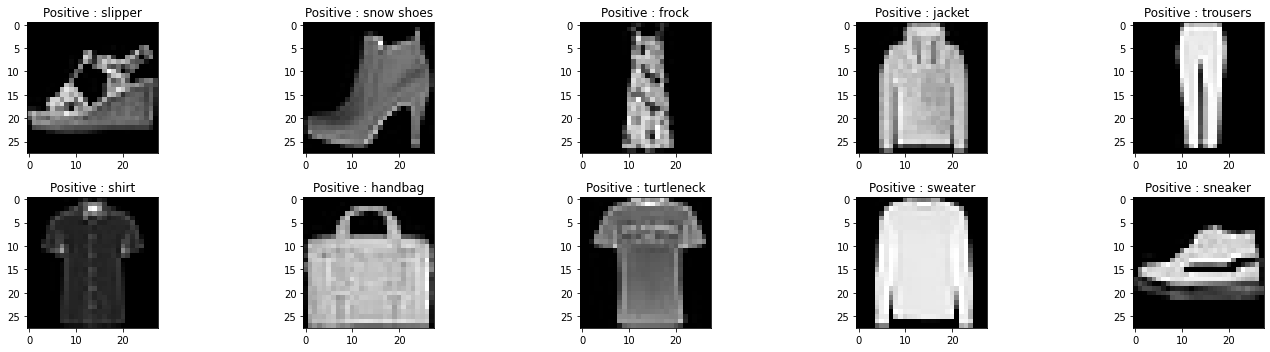

In [ ]:
fig2, ax2 = plt.subplots(2, 5, figsize = (20, 5))
list1 = []
count = 0
idx_list = list(range(len(y_original)))
np.random.shuffle(idx_list)
for i in idx_list:
    if y_original[i] not in list1:
        list1.append(y_original[i])

        ax = ax2[count // 5, count % 5]
        ax.imshow(X[i], cmap = 'gray')
        ax.set_title("Positive : " + y_train[i])
        
        count += 1
plt.tight_layout()
plt.show()

We will start be preprocessing the label descriptions. It is important that though we use label descriptions without punctuation, it is important that the tokenizer considers potential punctuation

In [ ]:
encoder = LabelEncoder()
encoder = encoder.fit(y_train)
y_train_encoded = encoder.transform(y_train)
y_test_encoded = encoder.transform(y_test)

y_train_oh = np_utils.to_categorical(y_train_encoded)
y_test_oh = np_utils.to_categorical(y_test_encoded)

In [ ]:
keys = encoder.classes_
values = encoder.transform(encoder.classes_)
dictionary = dict(zip(keys, values))
print(dictionary)

{'ankle boots': 0, 'backpack': 1, 'bag': 2, 'boots': 3, 'button down': 4, 'button up': 5, 'coat': 6, 'denims': 7, 'dress': 8, 'footwear': 9, 'frock': 10, 'galoshes': 11, 'gown': 12, 'handbag': 13, 'hoodie': 14, 'jacket': 15, 'jumper': 16, 'moccasin': 17, 'overcoat': 18, 'pants': 19, 'polo': 20, 'pullover': 21, 'purse': 22, 'robe': 23, 'running shoes': 24, 'sandal': 25, 'shirt': 26, 'slacks': 27, 'slip on': 28, 'slipper': 29, 'sneaker': 30, 'snow shoes': 31, 'sweater': 32, 't-shirt': 33, 'tennis shoes': 34, 'top': 35, 'trousers': 36, 'tunic': 37, 'turtleneck': 38, 'windbreaker': 39}


In [ ]:
class_labels = [["turtleneck", "top", "t-shirt", "tunic"],
                ["pants", "slacks", "trousers", "denims"],
                ["pullover", "jumper", "hoodie", "sweater"],
                ["dress", "gown", "frock", "robe"],
                ["coat", "jacket", "overcoat", "windbreaker"],
                ["slipper", "moccasin", "slip on", "sandal"],
                ["shirt", "button up", "button down", "polo"],
                ["sneaker", "running shoes", "footwear", "tennis shoes"],
                ["bag", "handbag", "purse", "backpack"],
                ["boots", "ankle boots", "galoshes", "snow shoes"]]

class_to_superclass_dict = {}

for idx, class_ in enumerate(class_labels):
    for syns in class_:
        class_to_superclass_dict[dictionary[syns]] = idx


In [ ]:
a = [1, 2, 6, 5, 4]
np.argmax(a)

2

In [ ]:
from collections import Counter

cnt = Counter(y_train)
count = dict(cnt)

most_common_syns = []

for class_ in class_labels:
    syn_count = [count[syn] for syn in class_]
    most_common_syn = np.argmax(syn_count)
    most_common_syns.append(class_[most_common_syn])

In [ ]:
most_common_syns

['top',
 'trousers',
 'jumper',
 'robe',
 'jacket',
 'moccasin',
 'button down',
 'tennis shoes',
 'bag',
 'snow shoes']

In [ ]:
most_common_syns_enc = [dictionary[x] for x in most_common_syns]
most_common_syns_enc

[35, 36, 16, 23, 15, 17, 4, 34, 2, 31]

In [ ]:
def chunker(sequence, size, shuffle = False):
    seq = sequence.copy()
    if shuffle == True:
        random.shuffle(seq)
    return [seq[pos:pos + size] for pos in range(0, len(seq), size)]

In [ ]:
def gen(list_images, list_captions_positive, batch_size=16, shuffle_batches = True):
    indexes = list(range(len(list_images)))
    while True:
        batches = chunker(indexes, batch_size, shuffle = shuffle_batches)

        for batch_indexes in batches:

            candidate_images = [list_images[i].reshape(28, 28, 1) for i in batch_indexes]
            candidate_labels = [list_captions_positive[i] for i in batch_indexes]

            X1 = np.array(candidate_images)
            X2 = np.array(candidate_labels)

            yield X1, X2

In [ ]:
next(gen(X, y_train_oh))

(array([[[[  0],
          [  0],
          [  0],
          ...,
          [  0],
          [  0],
          [  0]],
 
         [[  0],
          [  0],
          [  0],
          ...,
          [  0],
          [  0],
          [  0]],
 
         [[  0],
          [  0],
          [  0],
          ...,
          [  0],
          [  0],
          [  0]],
 
         ...,
 
         [[  0],
          [  0],
          [  0],
          ...,
          [  0],
          [  0],
          [  0]],
 
         [[  0],
          [  0],
          [  0],
          ...,
          [  0],
          [  0],
          [  0]],
 
         [[  0],
          [  0],
          [  0],
          ...,
          [  0],
          [  0],
          [  0]]],
 
 
        [[[  0],
          [  0],
          [  0],
          ...,
          [  0],
          [  0],
          [  0]],
 
         [[  0],
          [  0],
          [  0],
          ...,
          [  0],
          [  0],
          [  0]],
 
         [[  0],
    

In [ ]:
def model(lr = 0.0001):
    input_1 = Input(shape=(28, 28, 1))

    conv_1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1), name = "conv_1")
    pool_1 = MaxPooling2D((2, 2), name = "pool_1")
    dense_1 = Dense(40, activation = 'softmax', name = "dense_image_1")

    x1 = conv_1(input_1)
    x1 = pool_1(x1)
    x1 = Flatten()(x1)
    x1 = dense_1(x1)

    model = Model([input_1], x1)

    model.compile(loss = 'categorical_crossentropy', optimizer = Adam(lr), metrics = ['accuracy'])

    model.summary()

    return model

In [ ]:
model = model(lr = 0.00001)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense_image_1 (Dense)        (None, 40)                216360    
Total params: 216,680
Trainable params: 216,680
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Split the data into train and val
from sklearn.model_selection import train_test_split

idx_list = list(range(len(X)))
train_idx, val_idx = train_test_split(idx_list, test_size = 0.2, shuffle = True, random_state = 2020)

train_imgs, train_labels = X[train_idx], y_train_oh[train_idx]
val_imgs, val_labels = X[val_idx], y_train_oh[val_idx]

In [ ]:
file_path = "model_triplet.h5"
BATCH_SIZE = 32

checkpoint = ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
es = EarlyStopping(monitor='val_accuracy', mode='auto', verbose=1, patience=10)
reduce_ = ReduceLROnPlateau(monitor="val_accuracy", mode='auto', patience=10, min_lr=1e-7)

history = model.fit(gen(train_imgs, train_labels, batch_size=BATCH_SIZE),
                    use_multiprocessing=True,
                    validation_data=gen(val_imgs, val_labels, batch_size=BATCH_SIZE), epochs=100,
                    verbose=1, workers=-1, steps_per_epoch=np.ceil(len(train_imgs) / BATCH_SIZE), validation_steps=np.ceil(len(val_imgs) / BATCH_SIZE), callbacks=[es, checkpoint, reduce_])
model.save_weights(file_path)

Epoch 1/100
1496/1500 [============================>.] - ETA: 0s - loss: 85.9074 - accuracy: 0.1253
Epoch 00001: val_accuracy improved from -inf to 0.16275, saving model to model_triplet.h5
1500/1500 [==============================] - 5s 3ms/step - loss: 85.8412 - accuracy: 0.1253 - val_loss: 57.3860 - val_accuracy: 0.1628
Epoch 2/100
1494/1500 [============================>.] - ETA: 0s - loss: 50.4165 - accuracy: 0.1754
Epoch 00002: val_accuracy improved from 0.16275 to 0.17800, saving model to model_triplet.h5
1500/1500 [==============================] - 5s 3ms/step - loss: 50.3809 - accuracy: 0.1754 - val_loss: 46.4578 - val_accuracy: 0.1780
Epoch 3/100
1496/1500 [============================>.] - ETA: 0s - loss: 42.6765 - accuracy: 0.1876
Epoch 00003: val_accuracy improved from 0.17800 to 0.18592, saving model to model_triplet.h5
1500/1500 [==============================] - 5s 3ms/step - loss: 42.6669 - accuracy: 0.1878 - val_loss: 41.5667 - val_accuracy: 0.1859
Epoch 4/100
1495/15

We will now evaluate the model performance

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


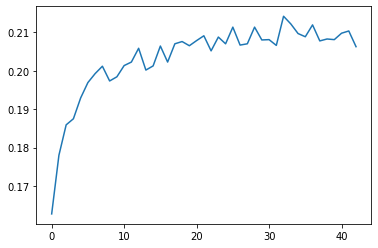

In [ ]:
plt.plot(history.history['val_accuracy'])

In [ ]:
predictions = model.predict(gen(x_test, y_test_oh, BATCH_SIZE, False), steps = np.ceil(len(x_test)/BATCH_SIZE),  use_multiprocessing= True, verbose = 1)

313/313 [==============================] - 1s 2ms/step


In [ ]:
ten_label_preds = np.zeros((len(predictions),))

for i, x in enumerate(predictions):
    syn_probs = x[most_common_syns_enc]
    pred_class = np.argmax(syn_probs)
    ten_label_preds[i] = pred_class

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
class_accs = []
for i in range(10):
    class_preds = [ten_label_preds[id] for id, x, in enumerate(y_test_original) if x == i]
    bin_labels = [1 if x == i else 0 for x in class_preds]
    class_acc = accuracy_score(bin_labels, [1]*len(bin_labels))
    class_accs.append(class_acc)

In [ ]:
np.mean(class_accs)

0.7926

In [ ]:
np.zeros((10,))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])